# 3 Implement SVM using a convex optimization package 20%

In [80]:
import numpy as np
import cvxopt
import numpy
from math import *
import random as rand
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix

### Primal Slack QP Algorithm taken from LFD, chapter 8

In [81]:
def primal(x,y):
    Q = [[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
    A = []
    for i in range(len(x)):
        a = [y[i]]
        b = [x[i][0]*y[i],x[i][1]*y[i]]
        A.append(a+b)
    p = [1.0,1.0,1.0]
    c = [0.0]*len(x)
    Q = matrix(Q)
    p = matrix(p)
    A = matrix(A)
    c = matrix(c)
    A = A.trans()
    sol = solvers.qp(Q,p,A,c)
    return sol 

### Function for checking whether it is this class or that class

In [82]:
def iris(w,x):
    if w[1]*x[0] + w[2]*x[1] + w[0] > 0:
        return 1
    else:
        return -1

### Extracting data from file and filling in required lists

In [83]:
f = open("iris.txt","r+")
data = f.readlines()
x = []
y = []
x_train = []
y_train = []
x_test = []
y_test = []



### Extracting only 2 features of Iris

In [84]:
for line in data:
    L = line.split(",")
    if L[4] == "setosa\n":
        x.append([float(L[0]),float(L[1])])
        y.append(1)
    elif L[4] == "versicolor\n":
        x.append([float(L[0]),float(L[1])])
        y.append(-1)
        


### 80% of present data is for training and 20% is for testing

In [85]:
for i in range(100):
    if i < 40 or i >= 50 and i < 90:
        x_train.append(x[i])
        y_train.append(y[i])
    else:
        x_test.append(x[i])
        y_test.append(y[i])

result_train = primal(x_train, y_train)
w = result_train["x"]
margin = 1/sqrt(w[0]*w[0] + w[1]*w[1] + w[2]*w[2])
print(margin)

     pcost       dcost       gap    pres   dres
 0: -9.9602e-01 -2.2348e+00  1e+02  1e+01  3e+01
 1: -2.6111e+00 -1.9770e+01  2e+01  2e+00  6e+00
 2: -3.2201e+00 -7.2026e+00  4e+00  4e-01  1e+00
 3: -3.6742e+00 -5.1700e+00  2e+00  1e-01  3e-01
 4: -3.6073e+00 -4.3230e+00  7e-01  3e-02  1e-01
 5: -3.6220e+00 -3.6317e+00  1e-02  3e-04  8e-04
 6: -3.6222e+00 -3.6223e+00  1e-04  3e-06  8e-06
 7: -3.6222e+00 -3.6222e+00  1e-06  3e-08  8e-08
Optimal solution found.
0.11528498611578583


### We have our weights now and can test our set with those weights

Test errors count: 0
Margin is 0.11528498611578583


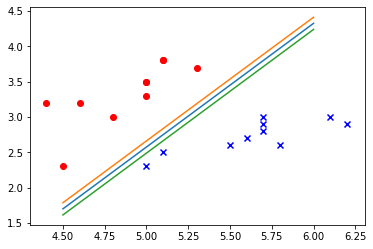

In [86]:
errors = 0
for i in range(len(x_test)):
    if iris(w,x_test[i]) == y_test[i]:
        errors += 1
print("Test errors count:",errors)
print("Margin is",margin)
for i in range(len(x_test)):
    if y_test[i] == 1:
        plt.scatter([x_test[i][0]],[x_test[i][1]],marker = "o", color = "red")
    else:
        plt.scatter([x_test[i][0]],[x_test[i][1]],marker = "x", color = "blue")
        
################################
x1 = 4.5
x2 = 6

y1 = (w[0]+w[1]*x1)/-w[2]
y2 = (w[0]+w[1]*x2)/-w[2]
plt.plot([x1,x2],[y1,y2])

y1 = (w[0]+margin+w[1]*x1)/-w[2]
y2 = (w[0]+margin+w[1]*x2)/-w[2]
plt.plot([x1,x2],[y1,y2])

y1 = (w[0]-margin+w[1]*x1)/-w[2]
y2 = (w[0]-margin+w[1]*x2)/-w[2]
plt.plot([x1,x2],[y1,y2])
#################################

f.close()

### Hard-Margin SVM with Dual QP taken from LFD chapter 8

In [87]:
def dual(X,Y):
    #Process of initializing required vectors
    ###########################################################
    Q = []
    A = []
    X = np.array(X)
    Y = np.array(Y)
    for i in range(len(X)):
        temp = []
        for j in range(len(Y)):
            y_product = Y[i]*Y[j]
            x_product = np.dot(y_product, np.transpose(X[i]))
            num = np.dot(x_product, X[j])
            temp.append(num)
        Q.append(temp)
    Y_temp = np.transpose(Y)
    Y_temp = np.dot(Y_temp,1.0)
    
    A.append(list(Y_temp))
    A.append(list(np.dot(Y_temp,-1.0)))
    
    temp_arr = [0.0]*len(X)
    for i in range(len(X)):
        temp_arr[i] = 1.0
        A.append(list(temp_arr))
        temp_arr[i] = 0.0
    minus_ones = [-1.0]*len(X)
    zeroes = [0.0]*(len(X)+2)
    
    A = matrix(A)
    A = A.trans()
    Q = matrix(Q)
    Q = Q.trans()
    minus_ones = matrix(minus_ones)
    zeroes = matrix(zeroes)
    ##########################################################
    sol = solvers.qp(Q,minus_ones,A,zeroes)
    alpha = sol["x"]
    print(alpha)
    
    w = [0.0]*len(X[0])
    w = np.array(w)
    index = -1
    
    for i in range(len(alpha)):
        if alpha[i] >= 0.0:
            index = i
        t = Y[i]*alpha[i]
        t = np.dot(t, X[i] )
        for j in range(len(w)):
            w[j] += t[j]
    b = 0
    if index != -1:
        b = y[index] - np.dot(np.transpose(w),x[index])
    print(index)
    return (w,b)

### Function for checking the correctness of class

In [88]:
def iris_2(x,w,b):
    if w[0]*x[0] + w[1]*x[1] + b >= 0:
        return 1
    else:
        return -1

### Extracting data

In [89]:
f = open("iris.txt","r+")
data = f.readlines()
x = []
y = []
x_train = []
y_train = []
x_test = []
y_test = []

for line in data:
    L = line.split(",")
    if L[4] == "setosa\n":
        x.append([float(L[0]),float(L[1])])
        y.append(1)
    elif L[4] == "versicolor\n":
        x.append([float(L[0]),float(L[1])])
        y.append(-1)
for i in range(100):
    if i < 40 or i >= 50 and i < 90:
        x_train.append(x[i])
        y_train.append(y[i])
    else:
        x_test.append(x[i])
        y_test.append(y[i])

### Testing our data

In [90]:
w = dual(x_train, y_train)
error = 0
print(list(w[0]),w[1])
for i in range(len(x_test)):
    if iris_2(x_test[i],list(w[0]),w[1]) == y_test[i]:
        error += 1
print(error)
f.close()

     pcost       dcost       gap    pres   dres
 0: -1.4773e+01  2.5269e+01  3e+02  2e+01  2e+00
 1:  5.4536e+00 -1.4528e+00  4e+01  2e+00  2e-01
 2:  1.9405e+00 -3.2927e-01  4e+00  1e-01  1e-02
 3:  2.6639e-01 -1.3255e-02  3e-01  2e-03  2e-04
 4:  9.0734e-03 -2.0473e-05  9e-03  3e-05  3e-06
 5:  9.1009e-05 -2.0727e-09  9e-05  3e-07  3e-08
 6:  9.1007e-07 -2.0727e-13  9e-07  3e-09  3e-10
 7:  9.1007e-09 -2.0727e-17  9e-09  3e-11  4e-12
Optimal solution found.
[-1.14e-10]
[-7.90e-11]
[-1.23e-10]
[-1.23e-10]
[-1.05e-10]
[-8.57e-11]
[-1.20e-10]
[-1.16e-10]
[-1.18e-10]
[-9.54e-11]
[-1.05e-10]
[-1.18e-10]
[-9.09e-11]
[-1.32e-10]
[-9.13e-11]
[-1.61e-10]
[-8.57e-11]
[-1.14e-10]
[-9.52e-11]
[-9.53e-11]
[-8.19e-11]
[-9.82e-11]
[-2.24e-10]
[-1.02e-10]
[-1.18e-10]
[-6.70e-11]
[-1.16e-10]
[-1.10e-10]
[-1.03e-10]
[-1.23e-10]
[-1.06e-10]
[-8.19e-11]
[-3.28e-10]
[-1.11e-10]
[-9.54e-11]
[-9.90e-11]
[-8.43e-11]
[-9.54e-11]
[-1.28e-10]
[-1.11e-10]
[-8.83e-11]
[-1.00e-10]
[-7.78e-11]
[-6.76e-11]
[-5.24e-